In [ ]:
# Install detectron2
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# Use the below line to install detectron2 if the above one has an error
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.6'

torch:  1.12 ; cuda:  cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.6) to /tmp/pip-req-build-szp57fnu
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-szp57fnu
  Running command git checkout -q d1e04565d3bec8719335b88be9e9b961bf3ec464
     |████████████████████████████████| 50 kB 4.6 MB/s 
     |████████████████████████████████| 79 kB 9.2 MB/s 
     |████████████████████████████████| 151 kB 72.4 MB/s 
     |████████████████████████████████| 130 kB 72.2 MB/s 
     |████████████████████████████████| 843 kB 62.9 MB/s 
     |████████████████████████████████| 596 kB 63.4 MB/s 
     |████████████████████████████████| 117 kB 78.7 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5206220 sha256=c0b7e7523a1d62e7e3ac680d8f181a6297e198746bdff2f421e5823ee3b485e0
  Stor

In [ ]:
# clone and install Detic
!git clone https://github.com/facebookresearch/Detic.git --recurse-submodules
%cd Detic
!pip install -r requirements.txt

Cloning into 'Detic'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 200 (delta 29), reused 26 (delta 23), pack-reused 139
Receiving objects: 100% (200/200), 3.59 MiB | 8.15 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Submodule 'third_party/CenterNet2' (https://github.com/xingyizhou/CenterNet2.git) registered for path 'third_party/CenterNet2'
Submodule 'third_party/Deformable-DETR' (https://github.com/fundamentalvision/Deformable-DETR.git) registered for path 'third_party/Deformable-DETR'
Cloning into '/content/Detic/third_party/CenterNet2'...
remote: Enumerating objects: 13921, done.        
remote: Counting objects: 100% (809/809), done.        
remote: Compressing objects: 100% (77/77), done.        
remote: Total 13921 (delta 759), reused 735 (delta 730), pack-reused 13112        
Receiving objects: 100% (13921/13921), 5.08 MiB | 8.92 MiB/s, done.
Resolving deltas: 100% (1

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import sys
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Detic libraries
sys.path.insert(0, 'third_party/CenterNet2/')
from centernet.config import add_centernet_config
from detic.config import add_detic_config
from detic.modeling.utils import reset_cls_test

In [ ]:
# Build the detector and download our pretrained weights
cfg = get_cfg()
add_centernet_config(cfg)
add_detic_config(cfg)
cfg.merge_from_file("configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand'
cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True # For better visualization purpose. Set to False for all classes.
# cfg.MODEL.DEVICE='cpu' # uncomment this to use cpu-only mode.
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth: 702MB [00:31, 22.3MB/s]                           


In [ ]:
# Setup the model's vocabulary using build-in datasets

BUILDIN_CLASSIFIER = {
    'lvis': 'datasets/metadata/lvis_v1_clip_a+cname.npy',
    'objects365': 'datasets/metadata/o365_clip_a+cnamefix.npy',
    'openimages': 'datasets/metadata/oid_clip_a+cname.npy',
    'coco': 'datasets/metadata/coco_clip_a+cname.npy',
}

BUILDIN_METADATA_PATH = {
    'lvis': 'lvis_v1_val',
    'objects365': 'objects365_v2_val',
    'openimages': 'oid_val_expanded',
    'coco': 'coco_2017_val',
}

vocabulary = 'lvis' # change to 'lvis', 'objects365', 'openimages', or 'coco'
metadata = MetadataCatalog.get(BUILDIN_METADATA_PATH[vocabulary])
classifier = BUILDIN_CLASSIFIER[vocabulary]
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)

Resetting zs_weight datasets/metadata/lvis_v1_clip_a+cname.npy


In [ ]:
import pathlib
DATA_DIR = pathlib.Path('../butterflies')
ramos_data = DATA_DIR / 'ramos'
zooniverse_data = DATA_DIR / 'zooniverse'

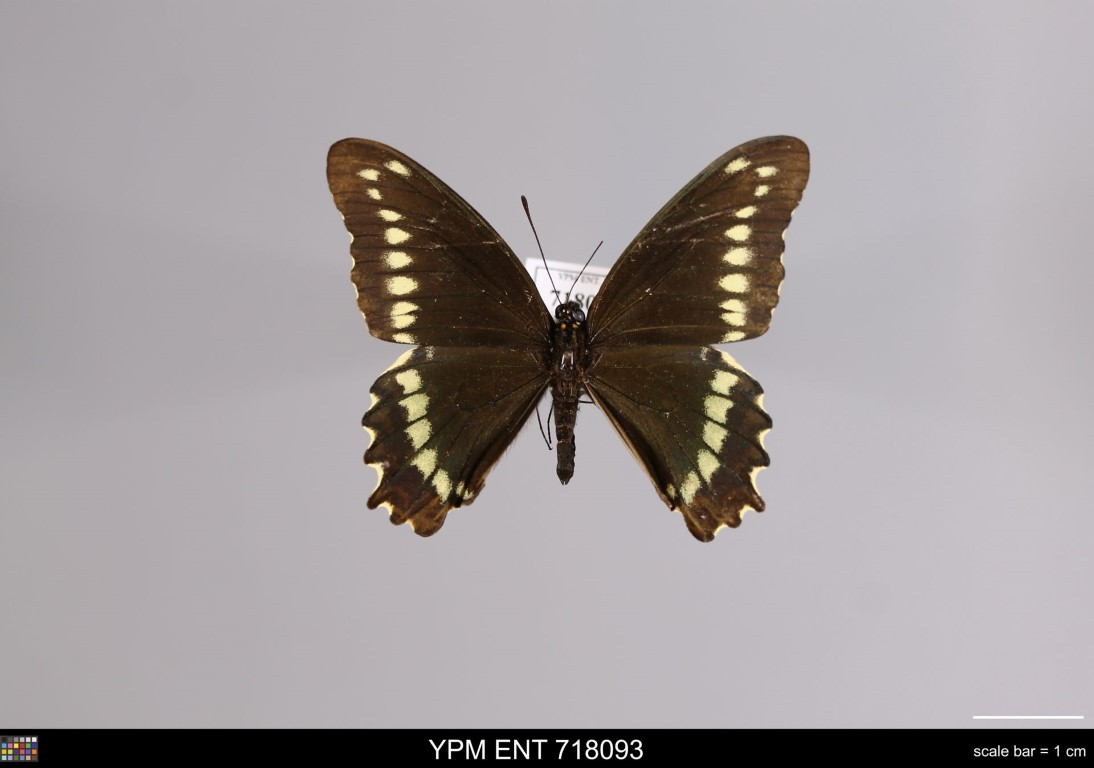

In [ ]:
# Download a sample image and display. Replace path here to try your own images!

im = cv2.imread((zooniverse_data / '000e2d18-452e-46cc-a858-1b7ba9fd3492.jpg').as_posix())
cv2_imshow(im)

In [ ]:
# Change the model's vocabulary to a customized one and get their word-embedding 
#  using a pre-trained CLIP model.

from detic.modeling.text.text_encoder import build_text_encoder
def get_clip_embeddings(vocabulary, prompt='a '):
    text_encoder = build_text_encoder(pretrain=True)
    text_encoder.eval()
    texts = [prompt + x for x in vocabulary]
    emb = text_encoder(texts).detach().permute(1, 0).contiguous().cpu()
    return emb
  
vocabulary = 'custom'
metadata = MetadataCatalog.get("__unused")
metadata.thing_classes = ['butterfly', 'ruler'] # Change here to try your own vocabularies!
classifier = get_clip_embeddings(metadata.thing_classes)
num_classes = len(metadata.thing_classes)
reset_cls_test(predictor.model, classifier, num_classes)
# Reset visualization threshold
output_score_threshold = 0.3
for cascade_stages in range(len(predictor.model.roi_heads.box_predictor)):
    predictor.model.roi_heads.box_predictor[cascade_stages].test_score_thresh = output_score_threshold

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 236MiB/s]


Loading pretrained CLIP


In [ ]:
import tqdm

In [ ]:
zooni_results = {}

In [ ]:
for im_path in tqdm.tqdm(zooniverse_data.glob('*.jpg')):
  im = cv2.imread(im_path.as_posix())
  outputs = predictor(im)
  class_names = [metadata.thing_classes[x]
                 for x in outputs["instances"].pred_classes.cpu().tolist()]
  scores = outputs["instances"].scores.cpu().numpy()

  zooni_results[im_path.name] = {
      'tags': class_names,
      'scores': scores
  }

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
651it [03:52,  2.80it/s]


In [ ]:
# save zooni_results
import pickle

In [ ]:
with open(DATA_DIR / 'zooniverse_results', 'wb') as f:
  pickle.dump(zooni_results, f)

In [ ]:
ramos_results = {}

In [ ]:
for im_path in tqdm.tqdm(ramos_data.glob('*.JPG')):
  im = cv2.imread(im_path.as_posix())
  outputs = predictor(im)
  class_names = [metadata.thing_classes[x]
                 for x in outputs["instances"].pred_classes.cpu().tolist()]
  scores = outputs["instances"].scores.cpu().numpy()

  ramos_results[im_path.name] = {
      'tags': class_names,
      'scores': scores
  }

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
587it [03:46,  2.59it/s]


In [ ]:
with open(DATA_DIR / 'ramos_results', 'wb') as f:
  pickle.dump(ramos_results, f)

# Plots

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import pickle

In [ ]:
with open('./ramos_results', 'rb') as f:
  ramos_results = pickle.load(f)

In [ ]:
with open('./zooniverse_results', 'rb') as f:
  zooniverse_results = pickle.load(f)

In [ ]:
ramos_butterfly_scores = []
ramos_ruler_scores = []
for im, vals in ramos_results.items():
  for tag, score in zip(vals['tags'], vals['scores']):
    if tag == 'butterfly':
      ramos_butterfly_scores.append(score)
    else:
      ramos_ruler_scores.append(score)

''

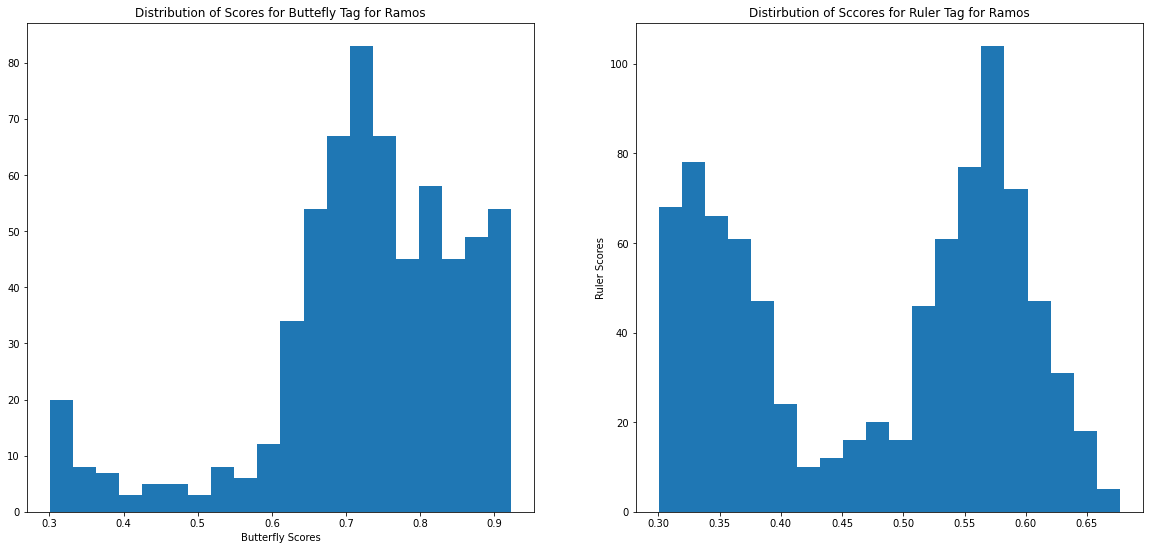

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 9))
ax[0].hist(ramos_butterfly_scores, bins=20)
ax[1].hist(ramos_ruler_scores, bins=20)

ax[0].set_xlabel('Butterfly Scores')
ax[1].set_ylabel('Ruler Scores')
ax[0].set_title('Distribution of Scores for Buttefly Tag for Ramos')
ax[1].set_title('Distribution of Sccores for Ruler Tag for Ramos')
;

In [ ]:
zooni_butterfly_scores = []
zooni_ruler_scores = []
for im, vals in zooniverse_results.items():
  for tag, score in zip(vals['tags'], vals['scores']):
    if tag == 'butterfly':
      zooni_butterfly_scores.append(score)
    else:
      zooni_ruler_scores.append(score)

''

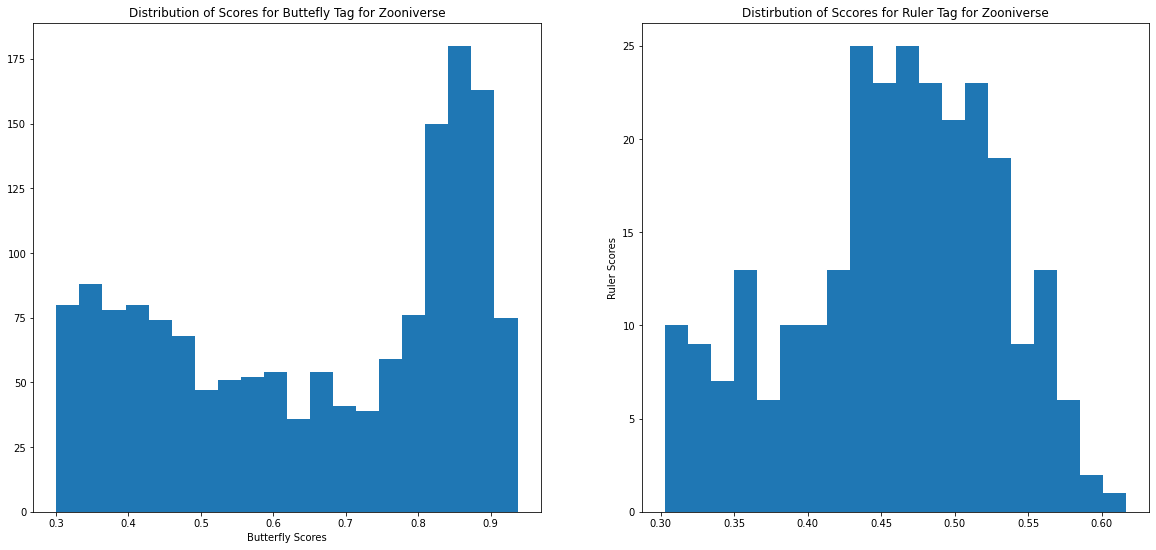

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 9))
ax[0].hist(zooni_butterfly_scores, bins=20)
ax[1].hist(zooni_ruler_scores, bins=20)

ax[0].set_xlabel('Butterfly Scores')
ax[1].set_ylabel('Ruler Scores')
ax[0].set_title('Distribution of Scores for Buttefly Tag for Zooniverse')
ax[1].set_title('Distirbution of Sccores for Ruler Tag for Zooniverse')
;

In [ ]:
# zooniverse is key, want as much variation as possible to handle museum data